In [42]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import random

from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [37]:
seed = 314
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

train_tfm  = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [38]:
batch_size = 128

train_set = DatasetFolder("training", loader=lambda x:Image.open(x), extensions="png", transform=train_tfm)
valid_set = DatasetFolder("validation", loader=lambda x:Image.open(x), extensions="png", transform=test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(4, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]
        x = self.cnn_layers(x)
        x = x.flatten(1)
        x = self.fc_layers(x)
        return x


In [41]:
# device = "cuda" if torch.cuda.is_available else "cpu"
device = "cpu"
cnn = CNN().to(device)
cnn.device = device

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0002, weight_decay=1e-5)

n_epochs = 80

all_train_losses = []
all_train_accs = []
all_valid_losses = []
all_valid_accs = []

for epoch in range(n_epochs):
    cnn.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = cnn(imgs.to(device))
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()

        grad_norm = nn.utils.clip_grad_norm(cnn.parameters(), max_norm=10)
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
    
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    cnn.eval()

    valid_loss = []
    valid_accs = []
    
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        with torch.no_grad():
            logits = cnn(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)  

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Validate | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}") 

    all_train_losses.append(train_loss)
    all_train_accs.append(train_acc)
    all_valid_losses.append(valid_loss)
    all_valid_accs.append(valid_acc)

     
    




100%|██████████| 8/8 [00:43<00:00,  5.41s/it]


[ Train | 001/080 ] loss = 0.40740, acc = 0.90328


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 001/080 ] loss = 0.60529, acc = 0.77054


100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


[ Train | 002/080 ] loss = 0.30585, acc = 0.89886


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


[ Validate | 002/080 ] loss = 0.58139, acc = 0.77054


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


[ Train | 003/080 ] loss = 0.23058, acc = 0.90866


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 003/080 ] loss = 0.52239, acc = 0.76757


100%|██████████| 8/8 [00:43<00:00,  5.43s/it]


[ Train | 004/080 ] loss = 0.18986, acc = 0.91940


100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


[ Validate | 004/080 ] loss = 0.42131, acc = 0.78358


100%|██████████| 8/8 [00:43<00:00,  5.48s/it]


[ Train | 005/080 ] loss = 0.15702, acc = 0.92622


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 005/080 ] loss = 0.37759, acc = 0.79844


100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


[ Train | 006/080 ] loss = 0.13472, acc = 0.93796


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


[ Validate | 006/080 ] loss = 0.42501, acc = 0.80290


100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


[ Train | 007/080 ] loss = 0.11760, acc = 0.95215


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 007/080 ] loss = 0.33514, acc = 0.85947


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


[ Train | 008/080 ] loss = 0.11260, acc = 0.95799


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 008/080 ] loss = 0.31777, acc = 0.86167


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 009/080 ] loss = 0.11222, acc = 0.95799


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 009/080 ] loss = 0.39524, acc = 0.83010


100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


[ Train | 010/080 ] loss = 0.10524, acc = 0.96435


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 010/080 ] loss = 0.29339, acc = 0.88661


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 011/080 ] loss = 0.09377, acc = 0.95946


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 011/080 ] loss = 0.24832, acc = 0.89739


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


[ Train | 012/080 ] loss = 0.10123, acc = 0.95261


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 012/080 ] loss = 0.39634, acc = 0.86279


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


[ Train | 013/080 ] loss = 0.10064, acc = 0.96385


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 013/080 ] loss = 0.29311, acc = 0.89512


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


[ Train | 014/080 ] loss = 0.08691, acc = 0.96287


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


[ Validate | 014/080 ] loss = 0.24181, acc = 0.91295


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


[ Train | 015/080 ] loss = 0.07955, acc = 0.96726


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 015/080 ] loss = 0.26675, acc = 0.90000


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


[ Train | 016/080 ] loss = 0.07680, acc = 0.97166


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


[ Validate | 016/080 ] loss = 0.28807, acc = 0.90402


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


[ Train | 017/080 ] loss = 0.07304, acc = 0.97070


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 017/080 ] loss = 0.41969, acc = 0.84974


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


[ Train | 018/080 ] loss = 0.07309, acc = 0.97168


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


[ Validate | 018/080 ] loss = 0.27795, acc = 0.90220


100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


[ Train | 019/080 ] loss = 0.07135, acc = 0.97066


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


[ Validate | 019/080 ] loss = 0.35548, acc = 0.88587


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 020/080 ] loss = 0.05985, acc = 0.97557


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


[ Validate | 020/080 ] loss = 0.30254, acc = 0.90147


100%|██████████| 8/8 [00:44<00:00,  5.50s/it]


[ Train | 021/080 ] loss = 0.05403, acc = 0.97852


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 021/080 ] loss = 0.31474, acc = 0.90293


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


[ Train | 022/080 ] loss = 0.05429, acc = 0.97605


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 022/080 ] loss = 0.35891, acc = 0.90297


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


[ Train | 023/080 ] loss = 0.05320, acc = 0.97898


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 023/080 ] loss = 0.33449, acc = 0.89847


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


[ Train | 024/080 ] loss = 0.06398, acc = 0.96628


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 024/080 ] loss = 0.57983, acc = 0.84828


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


[ Train | 025/080 ] loss = 0.05711, acc = 0.97704


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 025/080 ] loss = 0.43026, acc = 0.88396


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 026/080 ] loss = 0.05443, acc = 0.97603


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 026/080 ] loss = 0.34802, acc = 0.90555


100%|██████████| 8/8 [00:45<00:00,  5.74s/it]


[ Train | 027/080 ] loss = 0.04347, acc = 0.98290


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 027/080 ] loss = 0.32066, acc = 0.89923


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


[ Train | 028/080 ] loss = 0.05304, acc = 0.97752


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 028/080 ] loss = 0.40622, acc = 0.89547


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[ Train | 029/080 ] loss = 0.03728, acc = 0.98730


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 029/080 ] loss = 0.40585, acc = 0.89627


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[ Train | 030/080 ] loss = 0.03061, acc = 0.98926


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 030/080 ] loss = 0.34512, acc = 0.90555


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


[ Train | 031/080 ] loss = 0.02787, acc = 0.98681


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 031/080 ] loss = 0.58145, acc = 0.86725


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 032/080 ] loss = 0.03647, acc = 0.98926


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 032/080 ] loss = 0.50207, acc = 0.89066


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 033/080 ] loss = 0.02144, acc = 0.98974


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


[ Validate | 033/080 ] loss = 0.47375, acc = 0.90482


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


[ Train | 034/080 ] loss = 0.01896, acc = 0.99169


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 034/080 ] loss = 0.46883, acc = 0.89885


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


[ Train | 035/080 ] loss = 0.01617, acc = 0.99707


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 035/080 ] loss = 0.63134, acc = 0.86317


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


[ Train | 036/080 ] loss = 0.00938, acc = 0.99707


100%|██████████| 7/7 [00:17<00:00,  2.55s/it]


[ Validate | 036/080 ] loss = 0.67519, acc = 0.86913


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


[ Train | 037/080 ] loss = 0.00748, acc = 0.99805


100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


[ Validate | 037/080 ] loss = 0.62142, acc = 0.89327


100%|██████████| 8/8 [00:47<00:00,  5.97s/it]


[ Train | 038/080 ] loss = 0.00590, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 038/080 ] loss = 0.54003, acc = 0.90367


100%|██████████| 8/8 [00:45<00:00,  5.73s/it]


[ Train | 039/080 ] loss = 0.00383, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


[ Validate | 039/080 ] loss = 0.62238, acc = 0.89401


100%|██████████| 8/8 [00:47<00:00,  5.92s/it]


[ Train | 040/080 ] loss = 0.00306, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 040/080 ] loss = 0.70855, acc = 0.87876


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


[ Train | 041/080 ] loss = 0.00364, acc = 1.00000


100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


[ Validate | 041/080 ] loss = 0.57416, acc = 0.90182


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


[ Train | 042/080 ] loss = 0.00699, acc = 0.99707


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


[ Validate | 042/080 ] loss = 0.76617, acc = 0.88173


100%|██████████| 8/8 [00:45<00:00,  5.73s/it]


[ Train | 043/080 ] loss = 0.00306, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


[ Validate | 043/080 ] loss = 0.65231, acc = 0.89959


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


[ Train | 044/080 ] loss = 0.00279, acc = 0.99902


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


[ Validate | 044/080 ] loss = 0.62636, acc = 0.90293


100%|██████████| 8/8 [00:45<00:00,  5.71s/it]


[ Train | 045/080 ] loss = 0.00285, acc = 0.99902


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 045/080 ] loss = 0.83685, acc = 0.87318


100%|██████████| 8/8 [00:47<00:00,  5.98s/it]


[ Train | 046/080 ] loss = 0.00263, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 046/080 ] loss = 0.60145, acc = 0.90293


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


[ Train | 047/080 ] loss = 0.00172, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 047/080 ] loss = 0.78528, acc = 0.86687


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


[ Train | 048/080 ] loss = 0.00181, acc = 0.99902


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


[ Validate | 048/080 ] loss = 0.71114, acc = 0.89362


100%|██████████| 8/8 [00:45<00:00,  5.72s/it]


[ Train | 049/080 ] loss = 0.00117, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


[ Validate | 049/080 ] loss = 0.78824, acc = 0.89327


100%|██████████| 8/8 [00:45<00:00,  5.69s/it]


[ Train | 050/080 ] loss = 0.00198, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 050/080 ] loss = 0.82081, acc = 0.88584


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


[ Train | 051/080 ] loss = 0.00062, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


[ Validate | 051/080 ] loss = 0.69413, acc = 0.90440


100%|██████████| 8/8 [00:45<00:00,  5.72s/it]


[ Train | 052/080 ] loss = 0.00077, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


[ Validate | 052/080 ] loss = 0.78471, acc = 0.89512


100%|██████████| 8/8 [00:45<00:00,  5.72s/it]


[ Train | 053/080 ] loss = 0.00051, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


[ Validate | 053/080 ] loss = 0.80912, acc = 0.89031


100%|██████████| 8/8 [00:45<00:00,  5.73s/it]


[ Train | 054/080 ] loss = 0.00043, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 054/080 ] loss = 0.77922, acc = 0.89624


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


[ Train | 055/080 ] loss = 0.00033, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


[ Validate | 055/080 ] loss = 0.79374, acc = 0.89327


100%|██████████| 8/8 [00:45<00:00,  5.73s/it]


[ Train | 056/080 ] loss = 0.00032, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


[ Validate | 056/080 ] loss = 0.85333, acc = 0.88438


100%|██████████| 8/8 [00:45<00:00,  5.72s/it]


[ Train | 057/080 ] loss = 0.00031, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


[ Validate | 057/080 ] loss = 0.77773, acc = 0.90143


100%|██████████| 8/8 [00:45<00:00,  5.73s/it]


[ Train | 058/080 ] loss = 0.00037, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


[ Validate | 058/080 ] loss = 0.94085, acc = 0.89069


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


[ Train | 059/080 ] loss = 0.00030, acc = 1.00000


100%|██████████| 7/7 [00:18<00:00,  2.57s/it]


[ Validate | 059/080 ] loss = 0.81788, acc = 0.89327


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


[ Train | 060/080 ] loss = 0.00024, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 060/080 ] loss = 0.84761, acc = 0.89550


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


[ Train | 061/080 ] loss = 0.00020, acc = 1.00000


100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


[ Validate | 061/080 ] loss = 0.87089, acc = 0.89142


100%|██████████| 8/8 [00:45<00:00,  5.66s/it]


[ Train | 062/080 ] loss = 0.00019, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


[ Validate | 062/080 ] loss = 0.84623, acc = 0.89809


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


[ Train | 063/080 ] loss = 0.00021, acc = 1.00000


100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


[ Validate | 063/080 ] loss = 0.89163, acc = 0.89031


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


[ Train | 064/080 ] loss = 0.00017, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 064/080 ] loss = 0.82726, acc = 0.89439


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


[ Train | 065/080 ] loss = 0.00017, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


[ Validate | 065/080 ] loss = 0.82101, acc = 0.90032


100%|██████████| 8/8 [00:45<00:00,  5.71s/it]


[ Train | 066/080 ] loss = 0.00017, acc = 1.00000


100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


[ Validate | 066/080 ] loss = 0.86013, acc = 0.89439


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


[ Train | 067/080 ] loss = 0.00018, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


[ Validate | 067/080 ] loss = 0.82298, acc = 0.90032


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 068/080 ] loss = 0.00016, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


[ Validate | 068/080 ] loss = 0.98762, acc = 0.89327


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


[ Train | 069/080 ] loss = 0.00014, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 069/080 ] loss = 0.81625, acc = 0.90217


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


[ Train | 070/080 ] loss = 0.00015, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


[ Validate | 070/080 ] loss = 0.84162, acc = 0.89920


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


[ Train | 071/080 ] loss = 0.00015, acc = 1.00000


100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


[ Validate | 071/080 ] loss = 0.87477, acc = 0.88846


100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


[ Train | 072/080 ] loss = 0.00018, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


[ Validate | 072/080 ] loss = 0.81206, acc = 0.90513


100%|██████████| 8/8 [00:44<00:00,  5.50s/it]


[ Train | 073/080 ] loss = 0.00011, acc = 1.00000


100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


[ Validate | 073/080 ] loss = 0.86493, acc = 0.89031


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[ Train | 074/080 ] loss = 0.00014, acc = 1.00000


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


[ Validate | 074/080 ] loss = 0.88945, acc = 0.89142


100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


[ Train | 075/080 ] loss = 0.00015, acc = 1.00000


100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


[ Validate | 075/080 ] loss = 0.81859, acc = 0.90143


100%|██████████| 8/8 [00:45<00:00,  5.66s/it]


[ Train | 076/080 ] loss = 0.00011, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


[ Validate | 076/080 ] loss = 0.88751, acc = 0.89216


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


[ Train | 077/080 ] loss = 0.00010, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


[ Validate | 077/080 ] loss = 0.90504, acc = 0.89920


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[ Train | 078/080 ] loss = 0.00010, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


[ Validate | 078/080 ] loss = 0.89874, acc = 0.89439


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[ Train | 079/080 ] loss = 0.00010, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


[ Validate | 079/080 ] loss = 1.05297, acc = 0.89031


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


[ Train | 080/080 ] loss = 0.00010, acc = 1.00000


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]

[ Validate | 080/080 ] loss = 1.05513, acc = 0.88622


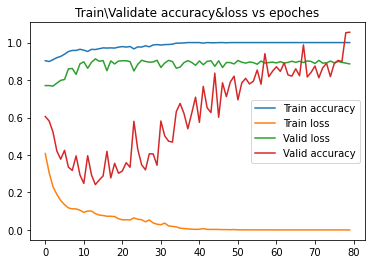

In [55]:
epoches = range(n_epochs)
plt.title("Train\Validate accuracy&loss vs epoches")
plt.plot(epoches, all_train_accs, label="Train accuracy")
plt.plot(epoches, all_train_losses, label="Train loss")
plt.plot(epoches, all_valid_accs, label="Valid loss")
plt.plot(epoches, all_valid_losses, label="Valid accuracy")
plt.legend(loc='best')
plt.savefig('result')

In [56]:
torch.save(cnn, "cnn1")